In [80]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
def use_svg_display():
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
set_figsize()


In [31]:
import pickle
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename
def load_variable(filename):
    f=open(filename,'rb')
    r=pickle.load(f)
    f.close()
    return r

In [85]:
def try_gpu(i=0):
    'Return gpu(i) if exists, otherwise return cpu().'
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [180]:
def convert(inputs):
    '''
    Convert network parameters to vector
    '''
    with torch.no_grad():
        if torch.is_tensor(inputs):
            inputs = [inputs] # [net.parameters()]
        else:
            inputs = list(inputs) # convert to list
        return torch.cat([x.contiguous().view(-1) for x in inputs])

def convert_reverse(inputs, net):
    '''
    Convert vector to network parameters
    '''
    with torch.no_grad():
        i = 0
        for x in list(net.parameters()):
            n = len(x.contiguous().view(-1))
            x.contiguous().view(-1).copy_(inputs[i:i+n])
            i += n

In [199]:
import time
class Timer:
    'Record multiple running times.'
    def __init__(self):
        self.times = []
        self.start()
 
    def start(self):
       self.tik = time.time()
 
    def stop(self):
       self.times.append(time.time() - self.tik)
       return self.times[-1]
 
    def avg(self):
        return sum(self.times) / len(self.times)
 
    def sum(self):
        return sum(self.times)
    def cumsum(self):
        return np.array(self.times).cumsum().tolist()
class Accumulator:
    'For accumulating sums over `n` variables.'
    def __init__(self, n):
        self.data = [0.0] * n
 
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
 
    def reset(self):
        self.data = [0.0] * len(self.data)
 
    def __getitem__(self, idx):
        return self.data[idx]

In [268]:
def train(net, train_iter, num_epochs, lr, device, test_iter=None):
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    timer, num_batches = Timer(), len(train_iter)
    train_ls, test_ls = [], []
    # train_accs, test_accs = [], []
    for epoch in range(num_epochs):
        metric = Accumulator(2)  
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[1]
            if (i + 1) % (num_batches // 1) == 0 or i == num_batches - 1:
                # print(f'{i}, train_loss: {train_l}')
                train_ls.append(train_l)
        if train_l < 1e-4:
            break
        net.eval()
        metric2 = Accumulator(2)
        if test_iter != None:
            with torch.no_grad():
                for (X_test,y_test) in test_iter:
                    X_test, y_test = X_test.to(device), y_test.to(device)
                    y_hat = net(X_test)
                    l = loss(y_hat, y_test)
                    metric2.add(l * X_test.shape[0], X_test.shape[0])
                test_l = metric2[0] / metric2[1]
                test_ls.append(test_l)
    if test_iter != None:
        print(f'train loss {train_l:.3f}', 
                f'test loss {test_l:.3f}')
    else:
        print(f'train loss {train_l:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    return train_ls, test_ls

## Generate target function

In [334]:
# One Hidden
num_inputs, num_outputs, num_hiddens = 1, 1, 2
loss = nn.MSELoss()
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.A = nn.Linear(num_hiddens, num_hiddens, bias=False)
        self.B = nn.Linear(num_inputs, num_hiddens, bias=False)
        self.sigma = nn.Tanh()
        self.output_layer = nn.Linear(num_hiddens, num_outputs, bias=False)
    def forward(self, x):
        H1 = x.new_zeros(num_hiddens)
        H1_old = H1.clone()
        for i in range(100):
            H1 = self.sigma(self.A(H1_old) + self.B(x))
            if torch.norm(H1 - H1_old) / num_hiddens < 1e-6:
                break
            H1_old = H1.clone()
        H2 = self.output_layer(H1)
        return H2
net_target = NeuralNetwork()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        # nn.init.normal_(m.weight, mean=0, std = 1e-1)
        # nn.init.normal_(m.bias, mean=0, std = 1e-1)  
torch.manual_seed(0) 
net_target.apply(init_weights)
# convert_reverse(torch.tensor([0.2, -0.1, -0.1, 0.2, 0.2, 0.1, 0.3, 0.1]), net_target)
list(net_target.parameters())

[Parameter containing:
 tensor([[-0.0092,  0.6570],
         [-1.0080, -0.9013]], requires_grad=True),
 Parameter containing:
 tensor([[-0.5447],
         [ 0.3792]], requires_grad=True),
 Parameter containing:
 tensor([[-0.0280,  1.1213]], requires_grad=True)]

In [299]:
def synthetic_data(num_example):
    x = torch.linspace(-15, 15, num_example).reshape(-1, 1)
    y = net_target(x).detach()
    return x, y
x, y = synthetic_data(50)
features_all = x.reshape(-1, 1)
labels_all = y.reshape(-1, 1)
dataset = torch.utils.data.TensorDataset(features_all, labels_all)

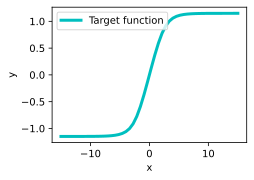

In [300]:
plt.plot(features_all, labels_all, linewidth=3, color='c', label='Target function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [301]:
train_size = 1
test_size = labels_all.shape[0] - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(0))

In [302]:
features_train = train_dataset[:][0]
labels_train = train_dataset[:][1]
features_test = test_dataset[:][0]
labels_test = test_dataset[:][1]

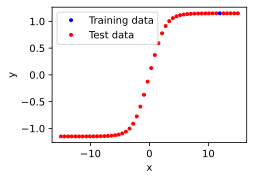

In [303]:
plt.plot(features_train, labels_train, '.', linewidth=3, color='b', label='Training data')
plt.plot(features_test, labels_test, '.', linewidth=3, color='r', label='Test data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Implicit Deep Learning

In [308]:
num_inputs, num_outputs, num_hiddens = 1, 1, 2
loss = nn.MSELoss()
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.A = nn.Linear(num_hiddens, num_hiddens, bias=False)
        self.B = nn.Linear(num_inputs, num_hiddens, bias=False)
        self.sigma = nn.Tanh()
        self.output_layer = nn.Linear(num_hiddens, num_outputs, bias=False)
    def forward(self, x):
        H1 = x.new_zeros(num_hiddens)
        H1_old = H1.clone()
        for i in range(100):
            H1 = self.sigma(self.A(H1_old) + self.B(x))
            if torch.norm(H1 - H1_old) / num_hiddens < 1e-6:
                break
            H1_old = H1.clone()
        H2 = self.output_layer(H1)
        return H2
net_implicit = NeuralNetwork()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        # nn.init.xavier_uniform_(m.weight)
        torch.manual_seed(0)
        nn.init.normal_(m.weight, mean = 0, std = 1e-5)
        # nn.init.normal_(m.bias, mean=0, std = 1e-1)   

train_size_ls = range(1, 20)
test_ls_dict_implicit = {}
batch_size, num_epochs, lr = 1024, 1000, 1e-2
for train_size in train_size_ls:
    test_size = labels_all.shape[0] - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(0))
    net_implicit.apply(init_weights)
    
    # convert_reverse(torch.tensor([0.1, 0.1, 0.1]), net_implicit)
    # list(net_target.parameters())

    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)
    test_iter = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)
    train_ls_implicit, test_ls_implicit = train(net_implicit, train_iter, num_epochs, lr, try_gpu(), test_iter=test_iter)
    test_ls_dict_implicit[train_size] = test_ls_implicit[-1]

training on cpu
train loss 0.000 test loss 0.019
12781.2 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.010
15961.5 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.011
30915.1 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.013
40997.3 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
7148.5 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
16893.6 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
24250.6 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
25820.9 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
27916.8 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
29211.1 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
30672.1 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
15768.8 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
16821.2 examples/sec on cpu


In [332]:
save_variable(test_ls_dict_implicit, '../../Output/test_ls_dict_implicit.npy')

'test_ls_dict_implicit.npy'

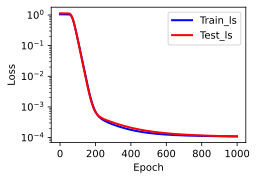

In [315]:
plt.plot(train_ls_implicit, linewidth=2, color='b', label='Train_ls')
plt.plot(test_ls_implicit, linewidth=2, color='r', label='Test_ls')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

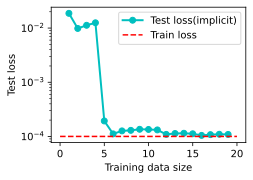

In [325]:
plt.plot(train_size_ls, test_ls_dict_implicit.values(), 'o-', linewidth=2, color='c', label='Test loss(implicit)')
plt.hlines(y=1e-4, xmin=0, xmax=20, color='r', linestyle='--', label='Train loss')
plt.xlabel('Training data size')
plt.ylabel('Test loss')
plt.legend()
plt.yscale('log')
plt.show()

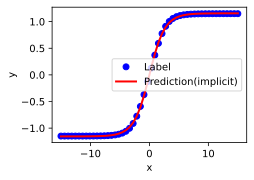

In [312]:
pred  = net_implicit(features_all).detach().numpy()
plt.plot(features_all, labels_all, 'o', linewidth=2, color='b', label='Label')
plt.plot(features_all, pred, linewidth=2, color='r', label='Prediction(implicit)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Normal deep learning

In [329]:
num_inputs, num_outputs, num_hiddens = 1, 1, 2
loss = nn.MSELoss()
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.B = nn.Linear(num_inputs, num_hiddens, bias=False)
        self.sigma = nn.Tanh()
        self.output_layer = nn.Linear(num_hiddens, num_outputs, bias=False)
    def forward(self, x):
        H1 = self.sigma(self.B(x))
        H2 = self.output_layer(H1)
        return H2
net = NeuralNetwork()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        # nn.init.xavier_uniform_(m.weight)
        torch.manual_seed(0)
        nn.init.normal_(m.weight, mean = 0, std = 1e-5)
        # nn.init.normal_(m.bias, mean=0, std = 1e-1)   

train_size_ls = range(1, 20)
test_ls_dict = {}
batch_size, num_epochs, lr = 1024, 1000, 1e-2
for train_size in train_size_ls:
    test_size = labels_all.shape[0] - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(0))
    net.apply(init_weights)
    
    # convert_reverse(torch.tensor([0.1, 0.1, 0.1]), net_implicit)
    # list(net_target.parameters())

    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)
    test_iter = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)
    train_ls, test_ls = train(net, train_iter, num_epochs, lr, try_gpu(), test_iter=test_iter)
    test_ls_dict[train_size] = test_ls[-1]

training on cpu
train loss 0.000 test loss 0.020
34649.4 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.011
43888.6 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.012
85473.0 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.014
127354.8 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
29629.0 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
52356.5 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
76030.4 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
89608.2 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
100944.1 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
106429.6 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
114677.7 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
125175.7 examples/sec on cpu
training on cpu
train loss 0.000 test loss 0.000
139557.1 examples/sec 

In [333]:
save_variable(test_ls_dict, '../../test_ls_dict.npy')

'test_ls_dict.npy'

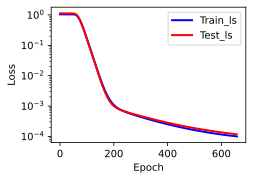

In [330]:
plt.plot(train_ls, linewidth=2, color='b', label='Train_ls')
plt.plot(test_ls, linewidth=2, color='r', label='Test_ls')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

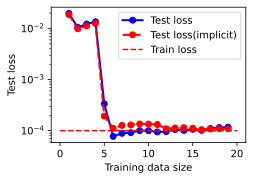

In [331]:
plt.plot(train_size_ls, test_ls_dict.values(), 'o-', linewidth=2, color='b', label='Test loss')
plt.plot(train_size_ls, test_ls_dict_implicit.values(), 'o--', linewidth=2, color='r', label='Test loss(implicit)')
plt.hlines(y=1e-4, xmin=0, xmax=20, color='r', linestyle='--', label='Train loss')
plt.xlabel('Training data size')
plt.ylabel('Test loss')
plt.legend()
plt.yscale('log')
plt.show()

## Theoretical Calculation

In [279]:
import sympy as sp
def sigmoid(x):
    return 1 / (1 + sp.exp(-x)) 

def relu(x):
    return sp.Piecewise((0, x < 0), (x, True))
sigmoid(1)

1/(exp(-1) + 1)

In [280]:
# Define variables and equation
x = sp.Symbol('x')
h = sp.Symbol('h')
A = sp.Symbol('A')
B = sp.Symbol('B')
eq = relu(A * h + B * x) - h
# eq = h - 2 * x
# Find roots
roots = sp.solve(eq, h)
# Print r
roots[0]

Piecewise((0, B*x < 0), (nan, True))

In [281]:
roots[1]

Piecewise((-B*x/(A - 1), B*x/(A - 1) <= 0), (nan, True))